http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import nsfg
import first
import analytic

import thinkstats2
import thinkplot

## Exercise 5.1

In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

In [2]:
import scipy.stats

For example <tt>scipy.stats.norm</tt> represents a normal distribution.

In [3]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

A "frozen random variable" can compute its mean and standard deviation.

In [4]:
dist.mean(), dist.std()

(178.0, 7.7)

It can also evaluate its CDF.  How many people are more than one standard deviation below the mean?  About 16%

In [5]:
dist.cdf(mu-sigma)

0.1586552539314574

How many people are between 5'10" and 6'1"?

In [6]:
# converting ft to cm
low = dist.cdf(177.8)
high = dist.cdf(185.4)
low, high, high-low

(0.48963902786483265, 0.8317337108107857, 0.3420946829459531)

## Exercise 5.2

To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [7]:
alpha = 1.7
xmin = 1       # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()

1.5034066538560549

What is the mean height in Pareto world?

In [8]:
dist.mean()

2.428571428571429

What fraction of people are shorter than the mean?

In [9]:
dist.cdf(dist.mean())

0.778739697565288

Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

In [10]:
(1 - dist.cdf(1000)) * 7e9
dist.sf(1000) * 7e9

55602.97643069972

How tall do we expect the tallest person to be?

In [11]:
dist.sf(600000) * 7e9

1.0525455861201714

## Exercise 6.1

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [12]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss
import density
import thinkstats2
import thinkplot

In [13]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, row.freq.astype(np.int64))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample

In [14]:
import hinc
income_df = hinc.ReadData()

In [15]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

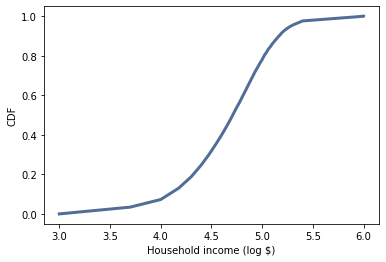

In [16]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [17]:
sample = np.power(10, log_sample)

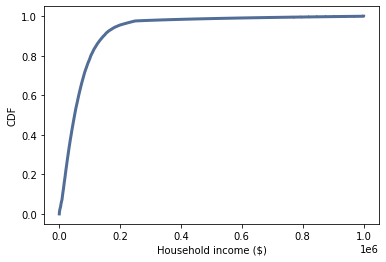

In [18]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [19]:
mean, median = density.Summarize(sample)

mean 74278.7075311872
std 93946.92996347835
median 51226.45447894046
skewness 4.949920244429583
pearson skewness 0.7361258019141782


In [20]:
cdf = thinkstats2.Cdf(sample)
print('cdf[mean]', cdf[mean])
print('cdf[median]', cdf[median])

cdf[mean] 0.660005879566872
cdf[median] 0.5


    About 66% report below the mean.

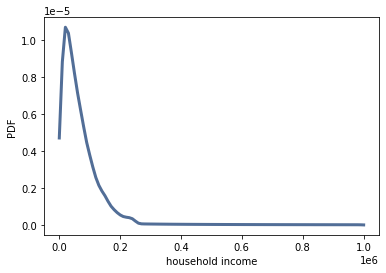

<Figure size 576x432 with 0 Axes>

In [21]:
pdf = thinkstats2.EstimatedPdf(sample)
thinkplot.Pdf(pdf)
thinkplot.Show(xlabel='household income', ylabel='PDF')

    Looking at the chart we can conclude that the lower the income gets, the higher chance taxable income isnt reported.